In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.optim import Adam
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [2]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.Tanh()
    )
    self.mu = nn.Linear(128,10)
    self.log_var = nn.Linear(128,10)
  def forward(self, x):
    x= x.view(-1,784)
    z = self.main(x)
    return self.mu(z), self.log_var(z)
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(10, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512,784),
        nn.Sigmoid()
    )
  def forward(self, z):
    x_prime = self.main(z)
    return x_prime.view(-1,28,28)
class VAE(nn.Module):
  def __init__(self,device):
    super(VAE, self).__init__()
    self.device = device
    self.enc = Encoder()
    self.dec = Decoder()
  def forward(self, x):
    mini_batch = x.shape[0]
    sample = torch.randn((mini_batch, 10),device = self.device)
    mu, log_var = self.enc(x)
    sample = mu + sample * (log_var/2).exp()
    x_prime = self.dec(sample)
    return x_prime, mu, log_var

In [3]:
# enc, dec=Encoder(), Decoder()
# print(enc(torch.rand(3,28,28)).shape, dec(torch.rand(3,128)).shape)
model = VAE(device = torch.device("cpu"))
x_prime ,mu, sigma = model(torch.rand(3,28,28))
print(x_prime.shape)

torch.Size([3, 28, 28])


In [13]:
epoch = 30
lr = 1e-4
batch_size =128

device = torch.device("cuda")
model = VAE(device =device)
model.to(device)
optimizer = Adam(model.parameters(), lr = lr)

transform = T.Compose([
      T.ToTensor()
])
train_data = MNIST(root="data",train=True, download= True, transform = transform)
valid_data = MNIST(root="data", train= False, download = True, transform= transform)
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle= True, num_workers=4)
val_loader= DataLoader(train_data, batch_size=batch_size, shuffle= False, num_workers=4)

BCE = nn.BCELoss(reduction = "sum")

for ep in range(epoch):
  train_loss = []
  valid_loss = []
  model.train()
  for idx, (img, label) in enumerate(train_loader):
    optimizer.zero_grad()
    img = img.to(device).squeeze(1)
    mini_batch = img.shape[0]
    x_prime, mu, log_var = model(img)
    loss = torch.sum((mu**2 +log_var.exp()- log_var -1))/2 +BCE(x_prime, img)
    loss/= mini_batch
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  model.eval()
  with torch.no_grad():
    for idx, (img, label) in enumerate(val_loader):
      img = img.to(device).squeeze(1)
      mini_batch = img.shape[0]
      x_prime, mu, log_var = model(img)
      loss = torch.sum((mu**2 +log_var.exp()- log_var- 1))/2 +BCE(x_prime, img)
      loss/= mini_batch
      valid_loss.append(loss.item())
model  print(f"[{ep}/{epoch}]: train: {round(np.mean(train_loss),2)}, valid: {round(np.mean(valid_loss),2)}")

[0/30]: train: 238.78, valid: 200.3
[1/30]: train: 193.07, valid: 185.43
[2/30]: train: 176.58, valid: 169.35
[3/30]: train: 163.37, valid: 158.79
[4/30]: train: 153.18, valid: 146.53
[5/30]: train: 143.21, valid: 140.0
[6/30]: train: 137.5, valid: 135.22
[7/30]: train: 133.64, valid: 132.06
[8/30]: train: 131.01, valid: 129.92
[9/30]: train: 128.77, valid: 127.4
[10/30]: train: 126.19, valid: 124.96
[11/30]: train: 124.19, valid: 123.28
[12/30]: train: 122.69, valid: 121.86
[13/30]: train: 121.35, valid: 120.63
[14/30]: train: 120.0, valid: 119.15
[15/30]: train: 118.54, valid: 117.79
[16/30]: train: 117.31, valid: 116.7
[17/30]: train: 116.37, valid: 116.0
[18/30]: train: 115.54, valid: 115.02
[19/30]: train: 114.81, valid: 114.4
[20/30]: train: 114.2, valid: 113.73
[21/30]: train: 113.58, valid: 113.19
[22/30]: train: 113.05, valid: 112.78
[23/30]: train: 112.53, valid: 112.08
[24/30]: train: 111.97, valid: 111.59
[25/30]: train: 111.39, valid: 110.99
[26/30]: train: 110.8, valid: 1

(3000, 10)


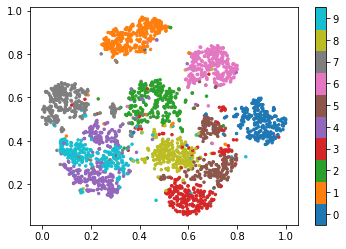

In [23]:
model.cpu()
torch.save(model.state_dict(), "vae.pth")
model.to(device)
model.eval()
mu_array = []
label_array = []
with torch.no_grad():
  for idx, (img,label) in enumerate(val_loader):
    img = img.to(device)
    x_prime, mu, log_var = model(img)
    mu_array.append(mu.detach().cpu().numpy())
    label_array.append(label)
mu_array = np.concatenate(mu_array, axis= 0)[:3000]
label_array = np.concatenate(label_array, axis = 0)[:3000]
print(mu_array.shape)
tsne = TSNE()
mu_visualization = tsne.fit_transform(mu_array)
# pca = PCA(n_components = 2)
# mu_visualization = pca.fit_transform(np.array(mu_array))
mu_visualization = (mu_visualization - mu_visualization.min())/(mu_visualization.max()- mu_visualization.min())

plt.scatter(mu_visualization[:,0],mu_visualization[:,1], c= label_array,s= 6, cmap = plt.cm.tab10 ,vmin = -.5, vmax = 9.5 )
plt.colorbar(ticks = range(10))
plt.savefig("scatter.png")

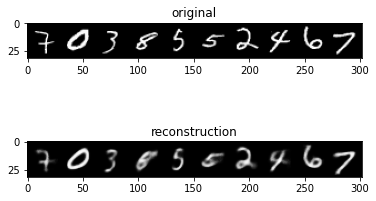

In [25]:
from random import randint
from torchvision.utils import make_grid
model.eval()
spec = randint(0,len(val_loader))
with torch.no_grad():
  for idx, (img,label) in enumerate(val_loader):
    if idx == spec:
      img = img.to(device)
      x_prime, mu, log_var = model(img)
      x,x_prime = img.detach().cpu()[:10], x_prime.detach().unsqueeze(1).cpu()[:10]
      break
plt.subplot(2,1,1)
plt.title("original")
plt.imshow(make_grid(x, nrow = 10, normalize = True).permute((1,2,0)))
plt.subplot(2,1,2)
plt.title("reconstruction")
plt.imshow(make_grid(x_prime, nrow = 10, normalize = True).permute((1,2,0)))
plt.savefig("reconstruct.png")



torch.Size([10]) torch.Size([10])
(10, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


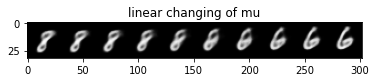

In [45]:
from random import randint
from torchvision.utils import make_grid
model.eval()
spec = randint(0,len(val_loader))
find4 = False
find9 = False
mu_4 = None
mu_9 = None
with torch.no_grad():
  for idx, (img,label) in enumerate(val_loader):
    if 4 in label and not find4:
      mask = label==6
      img_4 = img[mask].to(device)
      x_prime, mu_4, log_var = model(img_4)
      mu_4 = mu_4[0].cpu()
      find4 = True
    if 9 in label and not find9:
      mask = label==8
      img_9 = img[mask].to(device)
      x_prime, mu_9, log_var = model(img_9)
      mu_9= mu_9[0].cpu()
      find9= True
    if find4 and find9:
      break
print(mu_4.shape, mu_9.shape)
weight = []
for _ in range(10):
  weight.append(np.arange(10)/10)
weight = np.stack(weight, axis = -1).transpose((0,1))
print(weight.shape)

linear = mu_4 *weight + mu_9*(1-weight)
linear = torch.tensor(linear, dtype= torch.float,device = device)
x_prime= model.dec(linear).detach().cpu().unsqueeze(1)
# print(linear.shape)


plt.title("linear changing of mu")
plt.imshow(make_grid(x_prime, nrow = 10, normalize = True).permute((1,2,0)))
plt.savefig("linearchange8to6.png")


In [46]:
from google.colab import files
!zip -r /content/VAE.zip /content/VAE
files.download("/content/VAE.zip")

  adding: content/VAE/ (stored 0%)
  adding: content/VAE/Fig/ (stored 0%)
  adding: content/VAE/Fig/linearchange8to6.png (deflated 15%)
  adding: content/VAE/Fig/reconstruct.png (deflated 11%)
  adding: content/VAE/Fig/scatter.png (deflated 1%)
  adding: content/VAE/vae.pth (deflated 7%)
  adding: content/VAE/.ipynb_checkpoints/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>